# 이미지 로드 및 전처리 하기

In [1]:
from silence_tensorflow import silence_tensorflow
silence_tensorflow()

import tensorflow as tf
config = tf.compat.v1.ConfigProto(
gpu_options=tf.compat.v1.GPUOptions(
    per_process_gpu_memory_fraction=0.8
))
        
sess = tf.compat.v1.Session(config=config)

이번 예시는 세 가지 방법으로 이미지 데이터세트를 로드하고 전처리 하는 방법을 보여준다.

* 먼저 고급 Keras 사전 처리 유틸리티(예:[```tf.keras.preprocessing.image_dataset_from_directory```](https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory)) 및 레이어(예:[```tf.keras.layers.Rescaling```](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Rescaling))를 사용하여 디스크에서 이미지 디렉토리를 읽는다.
* 다음으로 [tf.data](https://www.tensorflow.org/guide/data?hl=ko)를 사용하여 처음부터 고유한 입력 파이프라인을 작성한다.
* 마지막으로 [Tensorflow Datasets](https://www.tensorflow.org/guide/data?hl=ko)에서 사용할 수 있는 대규모 [카탈로그](https://www.tensorflow.org/datasets?hl=ko)에서 데이터세트를 다운로드 한다.

## 0. 설정

In [2]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds

print(tf.__version__)

2.3.0


## 1. 꽃 데이터세트 다운로드하기

이번 예시는 수천장의 꽃 사진 데이터세트를 사용한다.<br/>
꽃 데이터세트에는 클래스당 하나씩 5개의 하위 디렉터리가 있다.<br/>
참고: 모든 이미지에는 CC-BY 라이선스가 있으며 크리에이터는 LICENSE.txt 파일에 나열된다.

In [3]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file(origin=dataset_url,
                                   fname='flower_photos',
                                   untar=True)
data_dir = pathlib.Path(data_dir)

다운로드 한 후, 이제 꽃 사진의 사본을 사용할 수 있다. 여기에는 총 3670개의 이미지가 있다.

In [4]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


각 디렉토리에는 해당 유형의 꽃 이미지가 포함되어있다.

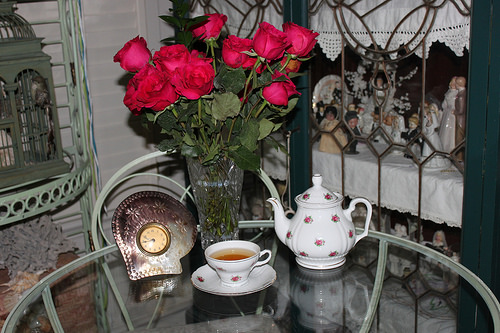

In [5]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[0]))

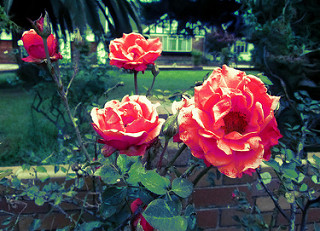

In [6]:
roses = list(data_dir.glob('roses/*'))


PIL.Image.open(str(roses[1]))

## 2. Keras 유틸리티를 사용하여 데이터 로드

유용한 [```tf.keras.preprocessing.image_dataset_from_directory```](https://www.tensorflow.org/versions/r2.3/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory) 유틸리티를 사용하여 디스크에서 이미지를 로드해보자.

## 2.1 데이터세트 만들기

로더를 위해 일부 매개변수를 정의한다.

In [7]:
batch_size = 32
img_height = 180
img_width = 180

모델을 개발할 때 검증 분할을 사용하는것이 좋다. 이미지의 80%를 훈련에 사용하고 나머지 20%를 검증에 사용한다.

In [8]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir,
                                                               validation_split=0.2,
                                                               subset="training",
                                                               seed=123,
                                                               image_size=(img_height, img_width),
                                                               batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [9]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir,
                                                             validation_split=0.2,
                                                             subset='validation',
                                                             seed=123,
                                                             image_size=(img_height, img_width),
                                                             batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


이러한 데이터세트의 ```class_names```속성에서 클래스 이름을 찾을 수 있다.

In [10]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


## 2.2 데이터 시각화하기

다음은 훈련 데이터세트의 처음 9개의 이미지이다.

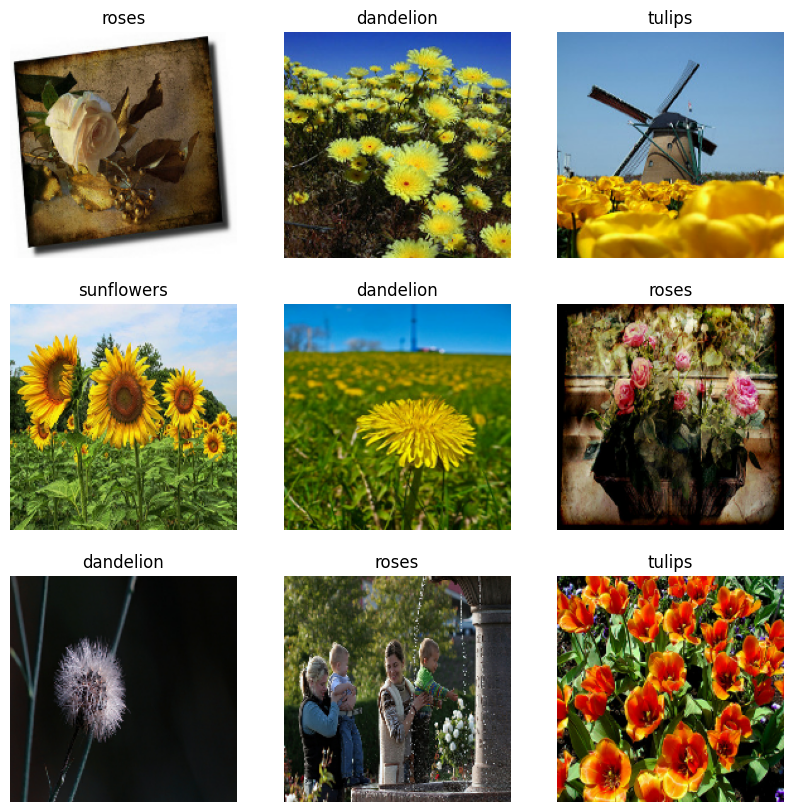

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i]])
        plt.axis('off')

이러한 데이터세트를 사용하는 모델을 ```model.fit```에 전달하여 모델을 훈련할 수 있다.<br/>
원하는 경우, 데이터세트를 수동으로 반복하고 이미지 배치를 검색할 수도 있다.

In [12]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 180, 180, 3)
(32,)


```image_batch```는 ```(32, 180, 180, 3)``` 형상의 텐서이며, ```180*180*3``` 형상의 32개의 이미지 묶음으로 되어있다.(마지막 차원은 색상채널 RGB를 의미)<br/>
```label_batch```는 ```(32, )```형상의 텐서이고 32개의 이미지에 해당하는 레이블이다.

이들 텐서 중 하나에서 ```.numpy()```를 호출하여 ```numpy.ndarray```로 변환할 수 있다.

## 2.3 데이터 표준화하기

RGB 채널값은 ```[0, 255]``` 범위에 있다. 이것은 신경망에 이상적이지 않기에, 일반적으로 입력 값을 작게 만든다.<br/>
여기에서 [```tf.keras.layers.experimental.preprocessing.Rescaling```](https://docs.w3cub.com/tensorflow~2.3/keras/layers/experimental/preprocessing/rescaling)을 사용하여 값을 ```[0, 1]``` 사이로 표준화한다.

In [13]:
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

이 레이어를 사용하는 방법에는 두 가지가 있다. [```Dataset.map```](https://www.tensorflow.org/api_docs/python/tf/data/Dataset?hl=ko#map)을 호출하여 데이터세트에 이를 적용할 수 있따.

In [14]:
normalized_ds = train_ds.map(lambda x,y:(normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
print(np.min(first_image),'/', np.max(first_image))

0.0 / 0.96902645


또는 모델 정의 내에 레이어를 포함해서 배포를 단순화할 수 있다.<br/>
여기에서는 두 번째 접근법을 사용할 것이다.

<참고><br/>
픽셀 값을 ```[-1, 1]```로 조정하려면 대신 ```tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset=-1)```을 작성할 수 있다.

<참고><br/>
이전에 [```tf.keras.preprocessing.image_dataset_from_directory```](https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory?hl=ko)의 ```image_size``` 인수를 사용하여 이미지 크기를 조정했다.<br/>해당 모델에도 크기 조정 논리를 포함하려면 [```tf.keras.layers.experimental.preprocessing.Resizing```](https://www.tensorflow.org/versions/r2.3/api_docs/python/tf/keras/layers/experimental/preprocessing/Resizing) 레이어를 사용할 수 있다.

## 2.4 성능을 위한 데이터세트 구성하기

버퍼링된 prefetch를 사용하여 I/O를 차단하지 않고 디스크에서 데이터를 생성할 수 있도록 해보자.<br/>
데이터를 로드할 때 다음 두가지 중요한 메서드를 사용해야 한다.

* [```Dataset.cache()```](https://www.tensorflow.org/api_docs/python/tf/data/Dataset?hl=ko#cache)는 첫 epoch동안 디스크에서 이미지를 로드한 후 이미지를 메모리에 유지한다.<br/>이렇게 하면 모델을 훈련하는 동안 데이터세트가 병목현상이 되지 않는다.<br/>데이터세트가 너무 커서 메모리에 맞지 않는 경우, 이 메서드를 사용하여 성능이 높은 온디스크 캐시를 생성할 수도 있다.<br/><br/>
* [```Dataset.prefetch```](https://www.tensorflow.org/api_docs/python/tf/data/Dataset?hl=ko#prefetch)는 훈련중에 데이터 전처리 및 모델 실행과 겹친다.

관심 있는 사람은 tf.data API를 통한 성능 향상 가이드의 프리페치 섹션에서 두 가지 메서드와 데이터를 디스크에 캐시하는 방법에 대해 자세히 알아볼 수 있습니다.

In [15]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## 2.5 모델 훈련하기

완성을 위해 방금 준비한 데이터세트를 사용하여 간단한 모델을 훈련하는 방법을 보여준다.

[Sequential 모델](https://www.tensorflow.org/guide/keras/sequential_model?hl=ko)은 각각에 최대 풀링 레이어([```tf.keras.layers.MaxPooling2D```](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D?hl=ko))가 있는 세 개의 컨벌루션 블록([```tf.keras.layers.Conv2D```](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D?hl=ko))으로 구성된다.<br/>
ReLU 활성화 함수에 의해 활성화되는 128개 유닛이 있는 완전 연결된 레이어(```tf.keras.layers.Dense```)가 있다.<br/>
이 모델은 어떠한 방식으로도 조정되지 않았다. 목표는 방금 생성한 데이터세트를 사용하여 메커니즘을 보여주는 것이다.

In [16]:
num_classes = 5

model = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(num_classes)
])

옵티마이저는 ```Adam```, 손실함수는 ```SparaseCategoricalCrossentropy```를 사용한다.

In [17]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [18]:
model.fit(train_ds,
          validation_data=val_ds,
          epochs=10)

Epoch 1/10
92/92 [==============================] - 6s 71ms/step - loss: 1.3272 - accuracy: 0.4448 - val_loss: 1.0823 - val_accuracy: 0.5749
Epoch 2/10
92/92 [==============================] - 3s 30ms/step - loss: 1.0477 - accuracy: 0.5875 - val_loss: 1.0256 - val_accuracy: 0.6076
Epoch 3/10
92/92 [==============================] - 3s 29ms/step - loss: 0.8992 - accuracy: 0.6553 - val_loss: 0.9338 - val_accuracy: 0.6403
Epoch 4/10
92/92 [==============================] - 3s 32ms/step - loss: 0.7400 - accuracy: 0.7204 - val_loss: 0.9472 - val_accuracy: 0.6253
Epoch 5/10
92/92 [==============================] - 3s 30ms/step - loss: 0.5617 - accuracy: 0.7847 - val_loss: 0.9474 - val_accuracy: 0.6471
Epoch 6/10
92/92 [==============================] - 3s 30ms/step - loss: 0.3976 - accuracy: 0.8552 - val_loss: 1.1968 - val_accuracy: 0.6117
Epoch 7/10
92/92 [==============================] - 3s 30ms/step - loss: 0.3303 - accuracy: 0.8815 - val_loss: 1.3323 - val_accuracy: 0.6526
Epoch 8/10
92

검증 정확도가 훈련 정확도보다 낮으므로 모델이 과대적합됨을 알 수 있다.

# 3. 미세 제어를 위해 [tf.data](https://www.tensorflow.org/api_docs/python/tf/data?hl=ko) 사용하기

위의 Keras 전처리 유틸리티 ```tf.keras.preprocessing.image_dataset_from_directory```는 이미지 디렉토리에서 ```tf.data.Dataset```을 생성하는 편리한 방법이다.

더 세밀한 제어를 위해 ```tf.data```를 사용하여 고유한 입력 파이프라인을 작성할 수 있다.<br/>
이 섹션에서는 이전에 다운로드한 TGZ 파일의 파일 경로부터 시작하여 이를 수행하는 방법을 보여준다.

In [19]:
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'), shuffle=False)
list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration=False)

In [20]:
for f in list_ds.take(5):
    print(f.numpy())

b'/home/ksc/.keras/datasets/flower_photos/tulips/16645809126_613b1e3ebe_m.jpg'
b'/home/ksc/.keras/datasets/flower_photos/tulips/8748266132_5298a91dcf_n.jpg'
b'/home/ksc/.keras/datasets/flower_photos/tulips/4418204816_018375acd0_m.jpg'
b'/home/ksc/.keras/datasets/flower_photos/roses/218630974_5646dafc63_m.jpg'
b'/home/ksc/.keras/datasets/flower_photos/daisy/3533954656_79156c8473.jpg'


파일의 트리구조를 사용하여 ```class_names``` 목록을 컴파일 할 수 있다.

In [21]:
class_names = np.array(sorted([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"]))
print(class_names)

['daisy' 'dandelion' 'roses' 'sunflowers' 'tulips']


데이터세트를 학습 및 검증 세트로 분할한다.

In [22]:
val_size = int(image_count * 0.2)
train_ds = list_ds.skip(val_size)
val_ds = list_ds.take(val_size)

다음과 같이 각 데이터세트의 길이를 인쇄할 수 있다.

In [23]:
print(tf.data.experimental.cardinality(train_ds).numpy())
print(tf.data.experimental.cardinality(val_ds).numpy())

2936
734


파일 경로를 ```(img, label)``` 쌍으로 변환하는 간단한 함수를 작성한다.

In [24]:
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    one_hot = parts[-2] == class_names
    return tf.argmax(one_hot)

In [25]:
def decode_img(img):
    img = tf.io.decode_jpeg(img, channels=3)
    return tf.image.resize(img, [img_height, img_width])

In [26]:
def process_path(file_path):
    label = get_label(file_path)
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

[```Dataset.map```](https://www.tensorflow.org/api_docs/python/tf/data/Dataset?hl=ko#map)을 사용하여 ```image, label```쌍의 데이터세트를 작성한다.

In [27]:
train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [28]:
for image, label in train_ds.take(1):
    print("Image shape :", image.numpy().shape)
    print("Label :", label.numpy())

Image shape : (180, 180, 3)
Label : 1


## 3.1 성능을 위한 데이터세트 구성하기

이 데이터세트로 모델을 훈련하려면 데이터에 다음이 필요하다.

* 잘 섞는다.
* 배치 처리한다.
* 가능한 빨리 배치를 사용할 수 있어야 한다.

이러한 기능은 [```tf.data```](https://www.tensorflow.org/api_docs/python/tf/data?hl=ko) API를 사용하여 추가할 수 있다.

In [29]:
def configure_for_performance(ds):
    ds = ds.cache()
    ds = ds.shuffle(buffer_size=1000)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)

## 3.2 데이터 시각화하기

이 데이터세트를 이전에 작성한 데이터세트와 유사하게 시각화 할 수 있다.

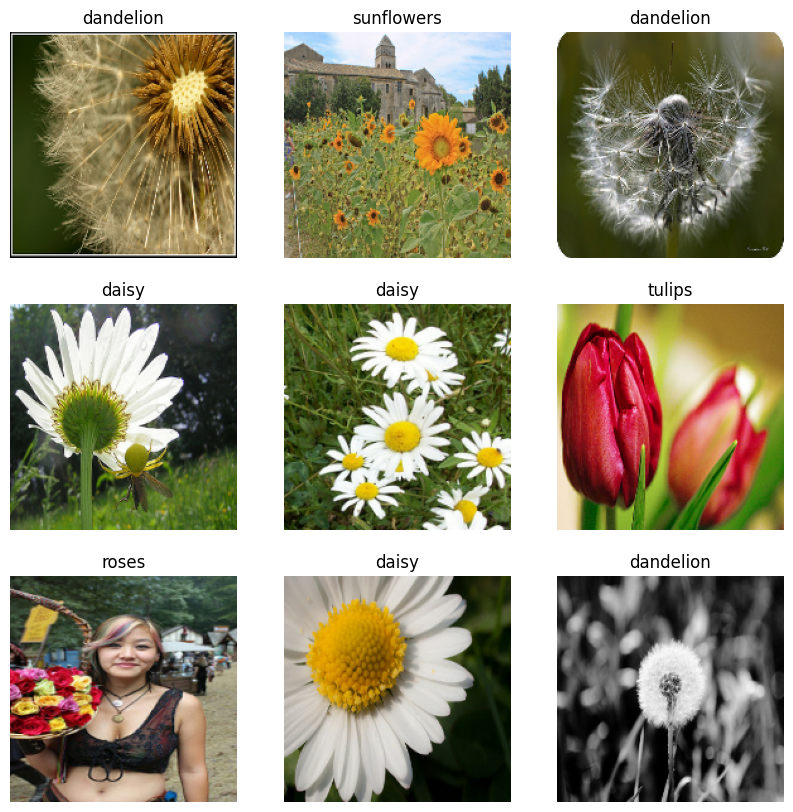

In [30]:
image_batch, label_batch = next(iter(train_ds))

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(image_batch[i].numpy().astype('uint8'))
    label = label_batch[i]
    plt.title(class_names[label])
    plt.axis('off')

## 3.3 모델 계속 훈련하기

이제 위의 ```tf.keras.preprocessing.image_dataset_from_directory```에 의해 생성된 것과 유사한 ```tf.data.Dataset```을 수동으로 구축했다.<br/>
이를 사용하여 모델을 계속 학습할 수 있다.

In [31]:
model.fit(train_ds,
          validation_data=val_ds,
          epochs=10)

Epoch 1/10
92/92 [==============================] - 4s 40ms/step - loss: 0.3688 - accuracy: 0.8917 - val_loss: 0.3381 - val_accuracy: 0.9101
Epoch 2/10
92/92 [==============================] - 3s 35ms/step - loss: 0.1178 - accuracy: 0.9704 - val_loss: 0.2996 - val_accuracy: 0.9319
Epoch 3/10
92/92 [==============================] - 3s 35ms/step - loss: 0.0382 - accuracy: 0.9918 - val_loss: 0.3416 - val_accuracy: 0.9237
Epoch 4/10
92/92 [==============================] - 3s 35ms/step - loss: 0.0189 - accuracy: 0.9969 - val_loss: 0.3951 - val_accuracy: 0.9087
Epoch 5/10
92/92 [==============================] - 3s 34ms/step - loss: 0.0109 - accuracy: 0.9976 - val_loss: 0.4079 - val_accuracy: 0.9183
Epoch 6/10
92/92 [==============================] - 3s 34ms/step - loss: 0.0061 - accuracy: 0.9993 - val_loss: 0.4165 - val_accuracy: 0.9223
Epoch 7/10
92/92 [==============================] - 3s 35ms/step - loss: 0.0044 - accuracy: 0.9997 - val_loss: 0.4363 - val_accuracy: 0.9183
Epoch 8/10
92

# 4. Tensorflow 데이터세트 사용하기

지금까지 이 튜토리얼은 디스크에서 데이터를 로드하는데 중점을 두었다.<br/>
[Tensorflow Datasets](https://www.tensorflow.org/datasets?hl=ko)에서 다운로드하기 쉬운 대규모 데이터세트 [카탈로그](https://www.tensorflow.org/datasets/catalog/overview?hl=ko)를 탐색하여 사용할 데이터세트를 찾을 수도 있다.

이전에 디스크에서 꽃 데이터세트를 로드했으므로 이제 Tensorflow 데이터세트로 가져오자.

In [32]:
(train_ds, val_ds, test_ds), metadata = tfds.load('tf_flowers',
                                                  split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
                                                  with_info=True,
                                                  as_supervised=True,)

꽃 데이터세트에는 5개의 클래스가 있다.

In [33]:
num_classes = metadata.features['label'].num_classes
print(num_classes)

5


데이터세트에서 이미지를 검색한다.

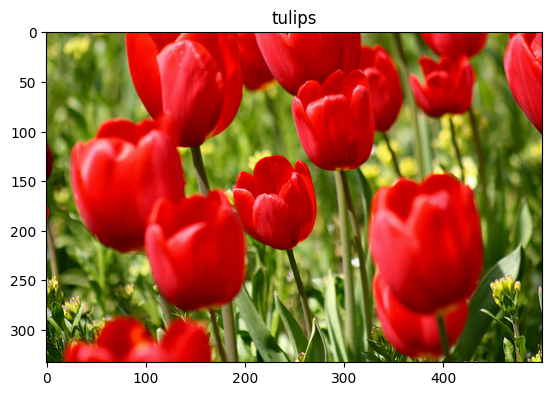

In [34]:
get_label_name = metadata.features['label'].int2str

image, label = next(iter(train_ds))
_ = plt.imshow(image)
_ = plt.title(get_label_name(label))

## 모델

TypeError: 'PrefetchDataset' object is not subscriptable